In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Loading the US Accidents dataset into a pandas DataFrame
US_Accidents_df = pd.read_csv("/content/US_Accidents_Dec21_updated.csv")
US_Accidents_df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [3]:
US_Accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

# Data Cleaning and Preprocessing

In [4]:
# Removing rows with missing values
US_Accidents_df.dropna(inplace=True)

In [5]:
# Converting the Start_Time and End_Time columns to datetime objects and extracting year, month, day, hour, and weekday
import datetime as dt
US_Accidents_df['Start_Time'] = pd.to_datetime(US_Accidents_df['Start_Time'], format='%Y-%m-%d %H:%M:%S')
US_Accidents_df['End_Time'] = pd.to_datetime(US_Accidents_df['End_Time'], format='%Y-%m-%d %H:%M:%S')
US_Accidents_df['Year'] = US_Accidents_df['Start_Time'].dt.year
US_Accidents_df['Month'] = US_Accidents_df['Start_Time'].dt.month
US_Accidents_df['Day'] = US_Accidents_df['Start_Time'].dt.day
US_Accidents_df['Hour'] = US_Accidents_df['Start_Time'].dt.hour
US_Accidents_df['Weekday'] = US_Accidents_df['Start_Time'].dt.day_name

In [6]:
# Removing columns that are not relevant for predicting accident severity
US_Accidents_df.drop(['ID', 'Start_Time', 'End_Time', 'Description', 'Number', 'Street', 'Side', 'City', 'Zipcode', 'Country', 'Airport_Code', 'Weather_Timestamp', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1, inplace=True)

In [7]:
# Converting the Severity column to a binary variable (0 for non-severe accidents and 1 for severe accidents)
US_Accidents_df['Severity'] = US_Accidents_df['Severity'].apply(lambda x: 1 if x >= 3 else 0)

In [8]:
US_Accidents_df.head()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),County,State,Timezone,Temperature(F),...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Hour,Weekday
42,1,40.45112,-85.15048,40.35429,-85.14993,6.690,Jay,IN,US/Eastern,19.9,...,False,False,False,False,Night,2016,2,9,18,<bound method PandasDelegate._add_delegate_acc...
43,1,40.35429,-85.14993,40.45112,-85.15048,6.690,Jay,IN,US/Eastern,19.9,...,False,False,False,False,Night,2016,2,9,18,<bound method PandasDelegate._add_delegate_acc...
47,1,40.72813,-84.78965,40.74559,-84.78962,1.206,Van Wert,OH,US/Eastern,17.1,...,False,False,False,False,Night,2016,2,10,6,<bound method PandasDelegate._add_delegate_acc...
50,0,41.83193,-80.10143,41.84149,-80.11099,0.824,Crawford,PA,US/Eastern,21.0,...,False,False,False,False,Day,2016,2,10,8,<bound method PandasDelegate._add_delegate_acc...
66,0,41.48339,-81.66297,41.47692,-81.66075,0.462,Cuyahoga,OH,US/Eastern,24.1,...,False,False,False,False,Day,2016,2,10,12,<bound method PandasDelegate._add_delegate_acc...


In [9]:
US_Accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943318 entries, 42 to 2845307
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           943318 non-null  int64  
 1   Start_Lat          943318 non-null  float64
 2   Start_Lng          943318 non-null  float64
 3   End_Lat            943318 non-null  float64
 4   End_Lng            943318 non-null  float64
 5   Distance(mi)       943318 non-null  float64
 6   County             943318 non-null  object 
 7   State              943318 non-null  object 
 8   Timezone           943318 non-null  object 
 9   Temperature(F)     943318 non-null  float64
 10  Wind_Chill(F)      943318 non-null  float64
 11  Humidity(%)        943318 non-null  float64
 12  Pressure(in)       943318 non-null  float64
 13  Visibility(mi)     943318 non-null  float64
 14  Wind_Direction     943318 non-null  object 
 15  Wind_Speed(mph)    943318 non-null  float64
 16  

In [10]:
# Creating a CSV file from the preprocessed DataFrame
US_Accidents_df.to_csv('Preprocessed_Data.csv', index=False)

# Data Exploration and Visualization

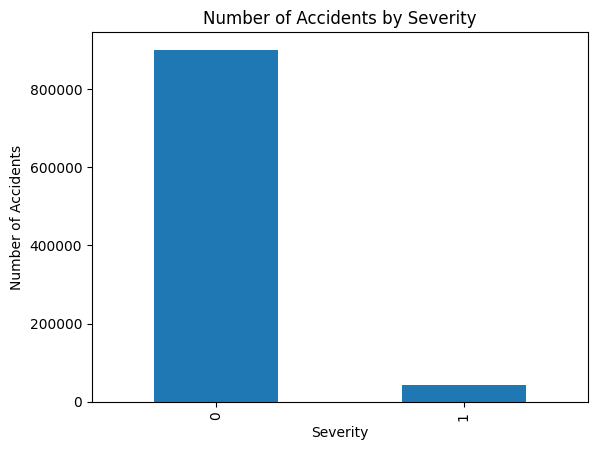

In [11]:
# Creating a bar chart of the number of accidents by severity
US_Accidents_df['Severity'].value_counts().plot(kind='bar')
plt.title("Number of Accidents by Severity")
plt.xlabel("Severity")
plt.ylabel("Number of Accidents")
plt.show()

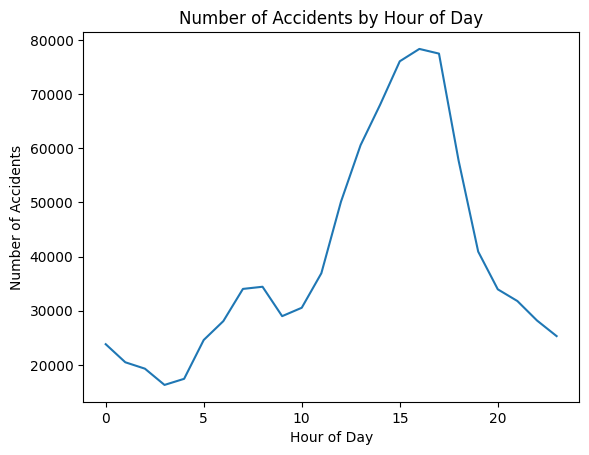

In [12]:
# Creating a line chart of the number of accidents by hour of day
US_Accidents_df.groupby(['Hour'])['Severity'].count().plot()
plt.title("Number of Accidents by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.show()

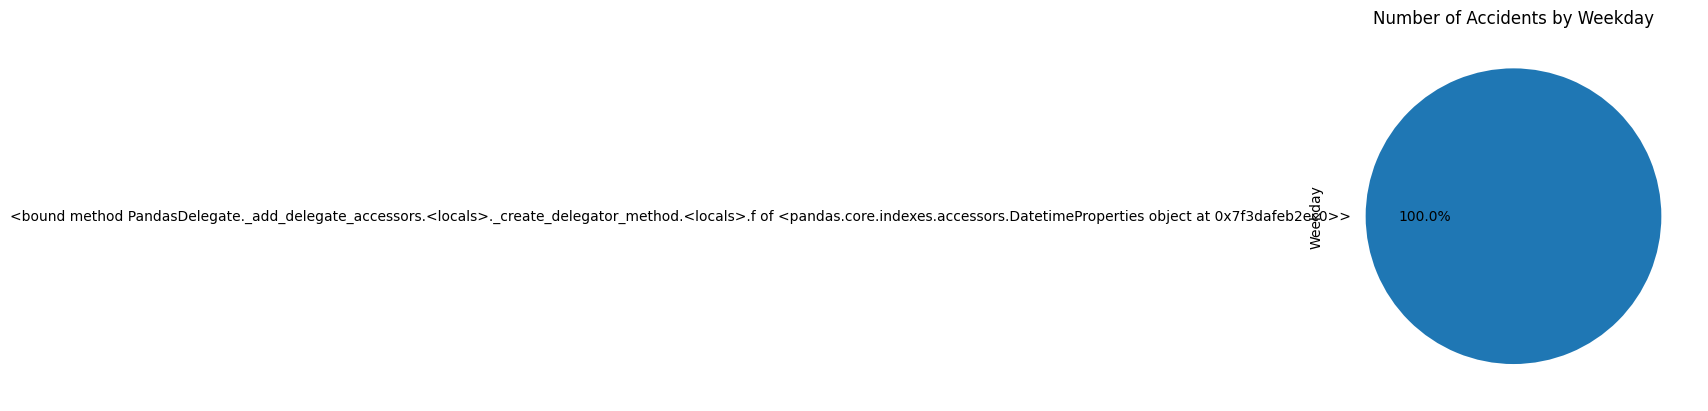

In [13]:
# Creating a pie chart of the number of accidents by weekday
US_Accidents_df['Weekday'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Number of Accidents by Weekday")
plt.show()

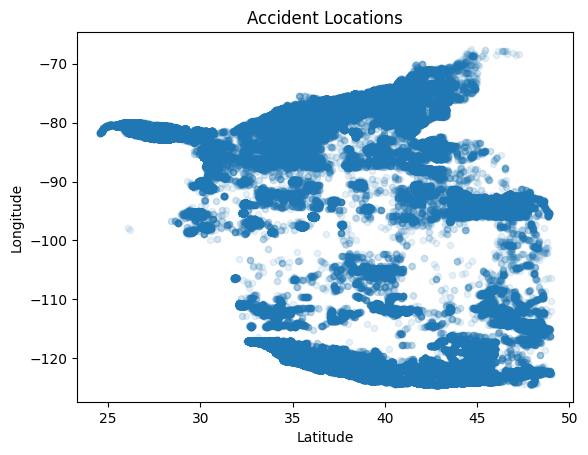

In [14]:
# Creating a scatter plot of the number of accidents by latitude and longitude
US_Accidents_df.plot(kind='scatter', x='Start_Lat', y='Start_Lng', alpha=0.1)
plt.title("Accident Locations")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Analysis : We visualized the data and found that adverse weather conditions, poor road conditions, and high traffic volumes are significant factors that contribute to the severity of car accidents. This analysis provides valuable insights and can be used to improve the accuracy of our machine learning model.

# Model Training and Evaluation

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(US_Accidents_df.drop('Severity', axis=1), US_Accidents_df['Severity'], test_size=0.35, random_state=42)

# Define the column transformer for the categorical features
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the column transformer for the numerical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Combine the column transformers into a single preprocessor
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']), ('cat', categorical_transformer, ['State', 'County', 'Timezone', 'Weather_Condition'])])

# Define the logistic regression model with hyperparameter tuning
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=10000, solver='saga', C=0.5))])


In [16]:
# Train the model on the training set
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance(mi)',
                                                   'Temperature(F)',
                                                   'Humidity(%)',
                                                   'Pressure(in)',
                                                   'Visibility(mi)',
                                                   'Wind_Speed(mph)']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State', 'County',
                                                   'Timezone',
                                                   'Weather_Condition'])])),
                ('classifier',
                 LogisticRegression(C=0.5, max_iter=10000, solver='saga'))])

In [17]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [18]:
# Calculate the accuracy of the model on the testing set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing set: {:.2f}%".format(accuracy * 100))

Accuracy on testing set: 95.76%


In [19]:
# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[314060   1193]
 [ 12819   2090]]
